In [ ]:
import sys
import os



# Get the absolute path of the directory containing the module
module_dir = os.path.abspath('../../src')

# Add the directory to sys.path
sys.path.insert(0, module_dir)
#for path in sys.path:
#    print(path)

import PySaRLAC as sl
import random
import math
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as pyplot
random.seed(1234)

In [8]:
#For reference, this is the mapping between operator index and operator name
idx_op_map = ["PiPiGnd","PiPiExc","Sigma"]
op_idx_map = dict()
for i in range(len(op_idx_map)):
    op_idx_map[idx_op_map[i]] = i


In [9]:
f = h5py.File('../../../combined_data.hdf5','r')

f.keys()

<KeysViewHDF5 ['bdj_data', 'j_data']>

In [10]:
#These are the operator pairs in the data set
jdata = f['j_data']
con = jdata['contains']['entries']
for e in con.keys():
    op1 = con[e].attrs["first"][0]
    op2 = con[e].attrs["second"][0]
    print(op1,op2,idx_op_map[op1],idx_op_map[op2])

0 0 PiPiGnd PiPiGnd
0 1 PiPiGnd PiPiExc
0 2 PiPiGnd Sigma
1 1 PiPiExc PiPiExc
1 2 PiPiExc Sigma
2 2 Sigma Sigma


In [ ]:
#Lets get the jackknife data now
#we'll store just the upper triangular part of the correlator matrix
Lt=64
block_size = 8
nsample_unblocked = 741
nblock = nsample_unblocked // block_size
jdata = f['j_data']
jdata_cors = [ [None for j in range(3)] for i in range(3)] #3 ops
for i in range(3):
    for j in range(i,3):
        jdata_cors[i][j] = sl.CorrelationFunction(Lt)
        cdata = jdata['correlators']['m']["elem_%d_%d" % (i,j)]['series']
        for t in range(Lt):
            jvals = cdata["elem_%d" % t]['second'].attrs['data']
            assert len(jvals) == nblock
            jdist = sl.JackknifeDistribution(nblock)
            for s in range(nblock):
                jdist[s] = jvals[s]                        
            print(i,j,t,jdist)
            jdata_cors[i][j].setValue(t, jdist)
            jdata_cors[i][j].setCoord(t, float(t))

0 0 0 1720533968568.517334 +- 5152527015.142453
0 0 1 1308082730816.283691 +- 3838743441.830425
0 0 2 817893517712.709229 +- 2863212729.101227
0 0 3 546447262835.104431 +- 2279669730.728789
0 0 4 371442428617.719116 +- 1977207304.061023
0 0 5 255425904124.481415 +- 1755689182.491866
0 0 6 176186513933.533051 +- 1675816329.593119
0 0 7 121975341117.497650 +- 1675622507.859246
0 0 8 84486142123.333389 +- 1765400455.676582
0 0 9 58249791177.174446 +- 1879393121.904631
0 0 10 39940393601.323479 +- 1958523855.933918
0 0 11 27648826491.399117 +- 1990866054.886972
0 0 12 18821224075.937077 +- 2002394932.749103
0 0 13 12563605837.880201 +- 1979220601.150931
0 0 14 8421808271.079186 +- 1890603345.313394
0 0 15 6006876270.216669 +- 1801576701.302305
0 0 16 4230730202.962997 +- 1728716806.666870
0 0 17 3130040947.329866 +- 1666463901.359768
0 0 18 2141599622.018576 +- 1550578630.086805
0 0 19 1759634993.427925 +- 1447183512.452421
0 0 20 1391825459.095830 +- 1405494121.983228
0 0 21 1310339203.70

In [12]:
#For block double jackknife we expect a flattened array of size nblock * ( block_size*nblock - block_size ) = 66976
nouter_samp = nblock
ninner_samp = block_size*nblock - block_size
nunrolled= nouter_samp * ninner_samp
bdjdata = f['bdj_data']
bdjdata_cors = [ [None for j in range(3)] for i in range(3)]  #3 ops
for i in range(3):    
    for j in range(i,3):
        cdata = bdjdata['correlators']['m']["elem_%d_%d" % (i,j)]['series']   
        bdjdata_cors[i][j] = sl.CorrelationFunction(Lt)
        for t in range(Lt):
            jvals = np.array(cdata["elem_%d" % t]['second']['data']['unrolled_data'])
            assert len(jvals) == nunrolled
            jdist = sl.BlockDoubleJackknifeDistribution(nsample_unblocked, block_size)
            assert jdist.size() == nouter_samp and jdist[0].size() == ninner_samp
            u = 0
            for so in range(nouter_samp):
                jdist[so].sampleVector()[:] = jvals[u:u+ninner_samp]
                u+=ninner_samp
                #for si in range(ninner_samp):
                #    jdist[so][si] = jvals[u]
                #    u+=1
            print(i,j,t,jdist[0])
            bdjdata_cors[i][j].setValue(t, jdist)
            bdjdata_cors[i][j].setCoord(t, float(t))

0 0 0 1719845318663.085205 +- 3798209038.402640
0 0 1 1307820430212.833252 +- 2909128936.388778
0 0 2 817699872842.041504 +- 2226474219.047954
0 0 3 546388343762.084473 +- 1891743760.051520
0 0 4 371412451290.504578 +- 1709324819.823354
0 0 5 255402156926.810364 +- 1594969223.744068
0 0 6 176168180006.580048 +- 1544164369.009320
0 0 7 121926989500.236908 +- 1539336947.822167
0 0 8 84393148446.034088 +- 1553080940.401558
0 0 9 58106579984.547539 +- 1580894996.621566
0 0 10 39740757238.679298 +- 1596126764.802656
0 0 11 27458288311.910011 +- 1605923635.424059
0 0 12 18649288516.866985 +- 1586350433.657506
0 0 13 12436689759.691626 +- 1558205219.299251
0 0 14 8320147316.048739 +- 1516845796.658208
0 0 15 5940132342.937119 +- 1479817202.220709
0 0 16 4193917768.962172 +- 1449018489.926064
0 0 17 3090201649.459730 +- 1440240086.797071
0 0 18 2086592091.158474 +- 1426946471.970658
0 0 19 1667299566.862962 +- 1429892895.633361
0 0 20 1301633731.376409 +- 1435983835.335167
0 0 21 1202635314.52

/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/JackknifeDistribution.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  self.samples[i] = val
/var/folders/4j/pqzs8n79443gwsk673x7591h0000gn/T/ipykernel_6487/2070114064.py:103: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(eig_val_t1_t0[i][j]) - log(eig_val_t_t0[i][j])) #-log(A/B)


(3, 3)
(3, 3)
[[-1.00000000e+00 -3.31032687e-14  1.12551391e-14]
 [ 2.18292397e-15 -1.00000000e+00  4.58052819e-14]
 [ 3.55720655e-15  1.97558399e-13 -1.00000000e+00]]
[0.35544564 0.35078986 0.3489428  0.34883247 0.3472825  0.3448936
 0.34392168 0.3419605  0.33768252 0.33608056]
Fitted constant: 0.34558321530692326


(0.0, 0.35544563935393353)

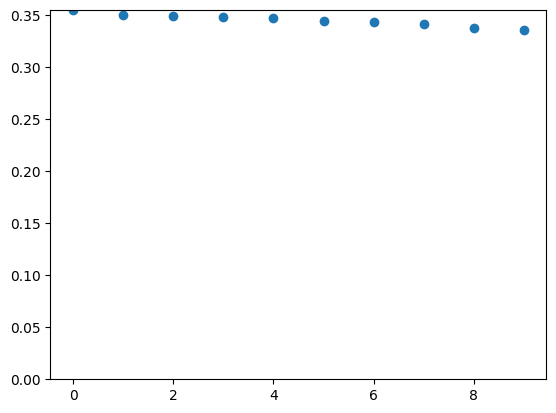

In [213]:
from scipy.linalg import eigh, eig
from numpy import log
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#print(jdata_cors[1][1].value(0).size())
#(jdata_cors[1][1].value(0)[0])

#print(np.shape(jdata_cors))


def gevp_eigv(data, t0, t):
    size = data[0][0].value(0).size()
    ev_result = [sl.JackknifeDistribution(size) for j in range(np.shape(data)[0])]  #Rename
    eigvec_result = np.zeros((size,3,3))
    #print(np.shape(eigvec_result))
    num_ops = np.shape(data)[0]
    Cmat = np.zeros((num_ops, num_ops), dtype=np.float64)
    Ct = np.zeros((num_ops, num_ops), dtype=np.float64)
    C_mats = np.zeros((size,3,3))
    C_t = np.zeros((size,3,3))
    for k in range(size):
        for i in range(np.shape(data)[0]):
            for j in range(np.shape(data)[0]):
                if i<=j:
                    Cmat[i][j] = data[i][j].value(t)[k]
                    Ct[i][j] = data[i][j].value(t0)[k]
                else:
                    Cmat[i][j] = data[j][i].value(t)[k]
                    Ct[i][j] = data[j][i].value(t0)[k]
        C_mats[k] = Cmat
        C_t[k] = Ct
        #try:
        eigvals, eigvecs = eig(Cmat, Ct)  #replace with eig package, see if all positive values
        idx = np.argsort(-eigvals) #Max eig value

        #sort both eigvals and eigvec
    
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:,idx]
            #print(eigvecs)
        #except np.linalg.LinAlgError:
            #eigvals = np.full(num_ops,np.nan) # Store failed matrix (Cmat and Ct) 3*3 matrix
        #    continue


        for m in range(num_ops):
            ev_result[m][k] = eigvals[m]
            eigvec_result[k][m] = eigvecs[m]

    return ev_result, eigvec_result, C_mats,C_t


def gevp_general(Ct, Cmat):

    eigvals, eigvecs = eig(Cmat, Ct)  #replace with eig package, see if all positive values
    idx = np.argsort(-eigvals) #Max eig value

    #sort both eigvals and eigvec

    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    return eigvals, eigvecs









def check_complex(gevp_val):
    t_min = 3
    t_max = 12
    for m in range(t_min,t_max-1):
        for n in range(m+1,t_max-1):
            for i in range(3):
                for j in range(3):
                    if np.imag(gevp_val(jdata_cors,n,m)[1][i][j].any()) < 1e-6:
                        pass
                    else:
                        print("Error, imag component")
                        break
    

def gevp(data, t0, t):
    ev_result = gevp_eigv(data, t0, t)[0]
    return ev_result


def eff_energy(data, t0, t, nth_state=None):
    size = data[0][0].value(0).size()
    eff_result = [sl.JackknifeDistribution(size) for j in range(np.shape(data)[0])]

    eig_val_t_t0 = gevp(data, t0, t)
    eig_val_t1_t0 = gevp(data, t0, t+1)

    for i in range(3):
        for j in range(size):
            # if log gives error return nan
            eff_result[i][j] = -(log(eig_val_t1_t0[i][j]) - log(eig_val_t_t0[i][j])) #-log(A/B)

    return eff_result 

#def new function of eff energy for specific state, compare implementations to check correctness, copy function above
#Check List:
# 1) Check if GEVP works for larger time for ground state (eig, isolating eff. energy func)
# 2) Rebased GEVP, check if V_ni elements are real, write code to check elements are real (Im(V)~0)


def rebased(C, eigvec):
    cov = np.zeros((3,3))
    #print(np.shape(eigvec))
    for i in range(3):
        for j in range(3):
            for i_in in range(3):
                for j_in in range(3):
                    cov[i][j] += eigvec[i,i_in] * C[i_in][j_in] * eigvec[j][j_in]

    return cov


def rebased1(C, eigvec):
    print(np.shape(eigvec))
    return eigvec.conj().T @ C @ eigvec

#print(rebased(gevp_eigv(jdata_cors,3,8)[2][0],gevp_eigv(jdata_cors,3,8)[1]))

ct = rebased1(gevp_eigv(jdata_cors,3,8)[2][0],gevp_eigv(jdata_cors,3,8)[1][0]) 
#ct = gevp_eigv(jdata_cors,3,8)[2][0]
ct0 = rebased1(gevp_eigv(jdata_cors,3,8)[3][0],gevp_eigv(jdata_cors,3,8)[1][0]) 
#ct0 = gevp_eigv(jdata_cors,3,8)[3][0]    

print(gevp_general(ct0,ct)[1])

#store C(t), C~(t)     
#E_eff = -(log(ev(t+1, t0)) - log(ev(t,t0)))
                 

        
    

#print(eff_energy(jdata_cors,1,8)[0])
#print(gevp(jdata_cors,4,8)[0])



gs_energy = np.array([[] for _ in range(10)])

N = 10  
gs_energy = np.empty(N, dtype=object)

for i in range(N):
    gs_energy[i] = []  


n = 12                
for i in range(1,n):         
    for j in range(i + 1, n): 
        #print(j-i)
        if eff_energy(jdata_cors,i,j)[0][0] > 0:

            gs_energy[j-i-1].append(eff_energy(jdata_cors,i,j)[0][0])

for i in range(len(gs_energy)):
    if isinstance(gs_energy[i], list):
        gs_energy[i] = np.array(gs_energy[i])


averages = np.array([np.mean(subarr) for subarr in gs_energy])

print(averages)

t_vals = np.arange(0,len(averages))

def constant_func(x, a):
    return a 

popt, pcov = curve_fit(constant_func, t_vals, averages)

#sum_i (1/E_i)*x_i <-- fit

print("Fitted constant:", popt[0])

plt.scatter(t_vals,averages)

plt.ylim(0, max(averages))

#plot energy as func of time with errors, tabulate


In [ ]:
from symb